In [1]:
from lib.logic import *
from lib.strategy_functions import *
from lib.widget import log_progress
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle
import timeit
from operator import attrgetter
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
import math

%matplotlib inline
%load_ext autoreload
%autoreload 2

colors = ["#eee4da","#ede0c8","#f2b179","#f59563",
          "#f67c5f","#f65e3b","#edcf72","#edcc61"
         "#edc850","#edc53f","#edc22e"]

MAX_SEQUENCE_SIZE = 6

In [2]:
def play_game(strategy):
    matrix = new_game(4)
    matrix = add_two(matrix)
    matrix = add_two(matrix)

    move_count = 0
    tries = 0
    current_state = 'starting'
    while current_state != 'win' and current_state != 'lose':
        next_move = strategy.next()
        matrix, done = next_move(matrix)
        if done: 
            strategy.successful_move()
            matrix = add_two(matrix)
            current_state = game_state(matrix)
            move_count += 1
            
    score = sum(sum(matrix, []))
    return score

def try_strategy(strategy, ngames):
    pool = mp.Pool(processes=6)
    processes = [pool.apply_async(play_game, args=(strategy,)) for i in range(ngames)]
    results = [p.get() for p in processes]
    strategy.store_results(results)
    strategy.compute_score()
    pool.close()
    pool.join()

# Compute and Play all strategies

In [3]:
def display_result_so_far(out, current_strategy, all_strategies):
    out.clear_output(wait=True)
    top = max(all_strategies, key=attrgetter('score'))    
    with out:
        print(current_strategy)
        x = [len(s.sequence) for s in all_strategies if s.score > 0]
        y = [s.score for s in all_strategies if s.score > 0]  
        plt.scatter(x, y, alpha=0.5)
        plt.scatter([len(current_strategy.sequence)], [current_strategy.score], color='orange', alpha=0.5)
        plt.scatter([len(top.sequence)], [top.score], color='red', alpha=0.5)
        plt.ylim(200, 825)
        plt.xlim(0, max_sequence_size+1)
        plt.xticks(range(0, max_sequence_size+1))
        plt.xlabel('Size of Sequence')
        plt.ylabel('Score')
        plt.show()

0: 7
1: 8
2: 14
3: 41
4: 134
5: 479
6: 1637


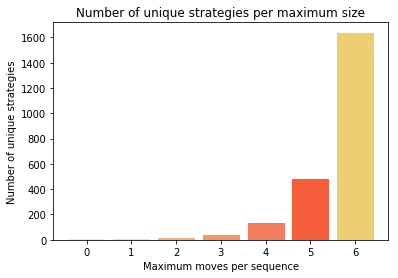


-------- COMPUTATION TIME --------
01:07:39


In [4]:
from itertools import product, permutations
start_time = timeit.default_timer()

# compute all possible combinations (could use a speed up)
all_strategies = []
sequence_sizes = []
for sequence_length in range(0, MAX_SEQUENCE_SIZE+1):
    sequence_combinations = product(POSSIBLE_MOVES, repeat=sequence_length)
    for c in sequence_combinations:
        stuck_sequence_combinations = permutations(POSSIBLE_MOVES, 4)
        for sc in stuck_sequence_combinations:        
            new_strategy = Strategy(list(c),list(sc))
            new_strategy.compress()                
            if new_strategy.is_valid() and new_strategy not in all_strategies:
                all_strategies.append(new_strategy)

        new_strategy = Strategy(list(c),[]) # random unstuck
        new_strategy.compress()
        if new_strategy.is_valid() and new_strategy not in all_strategies:
            all_strategies.append(new_strategy)

    print(str(sequence_length) + ': ' + str(len(all_strategies)))
    sequence_sizes.append(len(all_strategies))
    
pickle.dump(all_strategies,open('all_strategies.pickle','wb'))

barlist = plt.bar(range(0,len(sequence_sizes),1), sequence_sizes)
for index, color in enumerate(colors):
    if index >= len(sequence_sizes):
        break
    barlist[index].set_color(color)
plt.title('Number of unique strategies per maximum size')
plt.xlabel('Maximum moves per sequence')
plt.ylabel('Number of unique strategies')
plt.show()  

print()
print('-------- COMPUTATION TIME --------')
elapsed = timeit.default_timer() - start_time
m, s = divmod(elapsed, 60)
h, m = divmod(m, 60)
print("%02d:%02d:%02d" % (h, m, s))

In [5]:
strategy_start_time = timeit.default_timer()

all_strategies = pickle.load(open('all_strategies.pickle','rb'))

max_sequence_size = 0
for s in all_strategies:
    max_sequence_size = len(s.sequence) if max_sequence_size < len(s.sequence) else max_sequence_size

all_out = widgets.Output(layout=Layout(height='275px'))
display(all_out)
        
for strategy in log_progress(all_strategies, every=1, name='Strategies'):
    try_strategy(strategy,100)
    display_result_so_far(all_out, strategy, all_strategies)
        
print()
print('-------- TOP 5 STRATEGIES --------')
top5 = sorted(all_strategies, key=attrgetter('score'), reverse=True)[:5]
for strategy in top5:
    print(strategy)

print()
print('-------- COMPUTATION TIME --------')
strategy_elapsed = timeit.default_timer() - strategy_start_time
m, s = divmod(strategy_elapsed, 60)
h, m = divmod(m, 60)
print("%02d:%02d:%02d" % (h, m, s))

total_elapsed = timeit.default_timer() - start_time
m, s = divmod(total_elapsed, 60)
h, m = divmod(m, 60)
print('Total: %02d:%02d:%02d' % (h, m, s))

pickle.dump(all_strategies,open('all_strategies_results.pickle','wb'))

Output(layout=Layout(height='275px'))


-------- TOP 5 STRATEGIES --------
up, right, right, down, right [left] (817)
up, right, up, left [] (816)
up, right, down, right [] (812)
up, right, up, left [down] (805)
right, up, left, up [down] (800)

-------- COMPUTATION TIME --------
00:19:22
Total: 01:27:02


## Let's try the best strategy 1000 times!

up, right, right, down, right [left] (817)
757 +/- 218


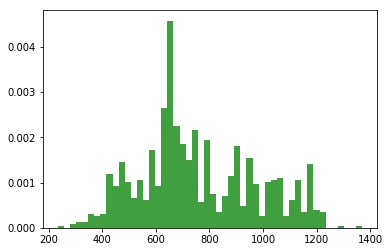

In [6]:
all_strategies = pickle.load(open('all_strategies_results.pickle','rb'))

import numpy as np
NGAMES = 1000
# sequence = [up, left, up, right]
# how_to_unstuck = []
# strategy = Strategy(sequence, how_to_unstuck)
strategy = max(all_strategies, key=attrgetter('score'))

print(strategy)
if strategy.is_valid():
    pool = mp.Pool(processes=6)
    processes = [pool.apply_async(play_game, args=(strategy,)) for i in range(NGAMES)]
    results = [p.get() for p in processes]
    pool.close()
    pool.join()

    print(str(int(np.mean(results))) + ' +/- ' + str(int(np.std(results))))
    n, bins, patches = plt.hist(results, 50, density=True, facecolor='g', alpha=0.75)
    plt.show()
else:
    print('Invalid strategy!')

# Random & Genomic Approach

In [14]:
def generate_random_strategy():
    sequence_length = random.randint(1, MAX_SEQUENCE_SIZE)
    sequence = []
    for i in range(0,sequence_length):
        sequence.append(random.choice(POSSIBLE_MOVES))        
    possible_stuck_moves = [move for move in POSSIBLE_MOVES if move not in sequence]
    random.shuffle(possible_stuck_moves)    
    stuck_sequence = possible_stuck_moves if random.random() > 0.5 else []
    return Strategy(sequence,stuck_sequence)

def compute_delta(generations,topn):
    delta_score_by_generation = []
    previous_score = 0
    for index, generation in enumerate(generations):
        scores = [strategy.score for strategy in generation[:topn]]
        average_score = int(sum(scores)/len(scores))            
        if index == 0:
            previous_score = average_score            
        delta = (average_score - previous_score)/previous_score
        delta_score_by_generation.append(delta)
        previous_score = average_score
    return delta_score_by_generation

def display_result_so_far(out, generations, topn, max_generations):
    out.clear_output(wait=True)
    with out:
        print('Generation ' + str(len(generations)))
        
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        x = [i for i in range(0, len(generations))]
        score_by_generation = []
        for generation in generations:
            scores = [strategy.score for strategy in generation[:topn]]
            average_score = int(sum(scores)/len(scores))
            score_by_generation.append(average_score)
        print('Average score of top genes: '+ str(average_score))
        
        y = score_by_generation                      
        plt.plot(x, y, alpha=0.5)
        plt.ylim(200, 875)
        plt.xlim(0, max_generations)
        plt.xlabel('Generation')
        plt.ylabel('Average Score')
        
        plt.subplot(1, 2, 2)
        x = [i for i in range(0, len(generations))]            
        y = compute_delta(generations,topn)       
        plt.plot(x, y, alpha=0.5)
        plt.axhline(0,color='grey',linewidth=1)
        plt.ylim(-0.35, 0.35)
        plt.xlim(0, max_generations)
        plt.xlabel('Generation')
        plt.ylabel('Average Score Delta')
        
        plt.tight_layout()
        plt.show()

In [15]:
def has_stabilized(generations, topn, minimum_gens):
    deltas = compute_delta(generations, topn)
    count = 0 
    for delta in deltas:
        if math.fabs(delta) < 0.05:
            count += 1
        else:
            count = 0
            
        if count > minimum_gens:
            return True
        
    return False

def compute_generations(use_mutation, run_all_generations,
                        genes_per_generation, portion_to_keep,
                        max_generations, runs_per_strategy,
                        minimum_gens, debug = True):
    
    top_to_keep = int(genes_per_generation*portion_to_keep)
    
    genetic_out = widgets.Output(layout=Layout(height='350px'))
    if debug:
        display(genetic_out)

    generations = []
    for generation_index in log_progress(range(0, max_generations), every=1 ,name='Generations', display_bar=debug):
        current_generation = generations[generation_index-1] if generation_index > 0 else []

        # first run => fill with random genes
        if not current_generation: 
            filled_with_random = 0
            while len(current_generation) < genes_per_generation:
                random_strategy = generate_random_strategy()
                if random_strategy not in current_generation:
                    random_strategy.set_parent_generation('Generation 0')
                    current_generation.append(random_strategy)
                    filled_with_random += 1
        else:
            current_generation = sorted(
                                    current_generation,
                                    key=attrgetter('score'),
                                    reverse=True)

            top_genes = current_generation[:top_to_keep]        
            current_generation = list(top_genes) # de-reference
            position = 0
            new_mutants = 0
            while len(current_generation) < genes_per_generation:
                if not use_mutation:
                    random_strategy = generate_random_strategy()
                    if random_strategy not in current_generation:
                        random_strategy.set_parent_generation('Generation ' + str(generation_index))
                        current_generation.append(random_strategy)
                        new_mutants += 1
                else:                
                    # first run everyone mutates!
                    if new_mutants < top_to_keep:
                        for strategy in top_genes:
                            new_strategy = Strategy(strategy.sequence, strategy.stuck_sequence)
                            
                            safety_mechanism = 0
                            while new_strategy in current_generation:
                                new_strategy.mutate(MAX_SEQUENCE_SIZE)
                                safety_mechanism += 1
                                if safety_mechanism > 10000:
                                    print('Safety mechanism activated. Maybe you have more genes than possible strategies?')
                                    break
                                    
                            new_strategy.set_parent_generation('Generation ' + str(generation_index))
                            current_generation.append(new_strategy)
                            new_mutants += 1
                    # after that, top gets more chances
                    else:
                        if random.random() < 0.20:
                            strategy = top_genes[position]
                            new_strategy = Strategy(strategy.sequence, strategy.stuck_sequence)
                            
                            safety_mechanism = 0
                            while new_strategy in current_generation:
                                new_strategy.mutate(MAX_SEQUENCE_SIZE)
                                safety_mechanism += 1
                                if safety_mechanism > 10000:
                                    print('Safety mechanism activated. Maybe you have more genes than possible strategies?')
                                    break
                                    
                            new_strategy.set_parent_generation('Generation ' + str(generation_index))
                            current_generation.append(new_strategy)
                            new_mutants += 1
                            position = 0  # set as zero so that first position has more chances
                        else:
                            position += 1
                            if position >= len(top_genes):
                                position = 0  
                                
                
        # run for all
        for strategy in current_generation:
            try_strategy(strategy, runs_per_strategy)

        # add list to generations
        scores = [strategy.score for strategy in current_generation[:top_to_keep]]
        generations.append(current_generation)
        
        if debug:
            display_result_so_far(genetic_out, generations, top_to_keep, max_generations)
        
        if not run_all_generations:
            if has_stabilized(generations, top_to_keep, minimum_gens):
                break            
        
    # Let's settle all the strategies
    if debug:
        with genetic_out:
            print('Settling results from last generation...')
        
    current_generation = sorted(current_generation, key=attrgetter('score'), reverse=True)
    for strategy in current_generation[:top_to_keep]:
        runs_to_thousand = 100 - len(strategy.results)
        if runs_to_thousand > 0:        
            try_strategy(strategy, runs_to_thousand)
        
    return generations

In [20]:
start_time = timeit.default_timer()

GENES_PER_GENERATION = 15
PORTION_TO_KEEP = 1/3
RUNS_PER_STRATEGY = 12

generations = compute_generations(
        use_mutation=False,
        run_all_generations=True,
        genes_per_generation=GENES_PER_GENERATION,
        portion_to_keep=PORTION_TO_KEEP,
        max_generations=20,
        runs_per_strategy=RUNS_PER_STRATEGY,
        minimum_gens=5,
        debug=True
    )
last_generation = generations[len(generations)-1]

print()
print('-------- NUMBER OF GENERATIONS --------')
print('Computed ' + str(len(generations)) + ' generations.')

print()
print('-------- LAST GENERATION --------')
last_generation = sorted(last_generation, key=attrgetter('score'), reverse=True)
for strategy in last_generation[:5]:
    print(strategy)

print()
print('-------- COMPUTATION TIME --------')
elapsed = timeit.default_timer() - start_time
m, s = divmod(elapsed, 60)
h, m = divmod(m, 60)
print("%02d:%02d:%02d" % (h, m, s))

Output(layout=Layout(height='350px'))


-------- NUMBER OF GENERATIONS --------
Computed 20 generations.

-------- LAST GENERATION --------
left, down, right, down [up] (836) [Generation 19]
right, up, right, down [] (818) [Generation 2]
down, right, down, left [up] (814) [Generation 16]
right, down, right, right, right, up [] (742) [Generation 8]
down, left, left, down, up, left [right] (620) [Generation 2]

-------- COMPUTATION TIME --------
00:01:06


In [37]:
start_time = timeit.default_timer()

GENES_PER_GENERATION = 15
PORTION_TO_KEEP = 1/3
RUNS_PER_STRATEGY = 12

generations = compute_generations(
        use_mutation=True,
        run_all_generations=False,
        genes_per_generation=GENES_PER_GENERATION,
        portion_to_keep=PORTION_TO_KEEP,
        max_generations=50,
        runs_per_strategy=RUNS_PER_STRATEGY,
        minimum_gens=5,
        debug=False
    )
last_generation = generations[len(generations)-1]

print()
print('-------- NUMBER OF GENERATIONS --------')
print('Computed ' + str(len(generations)) + ' generations.')

print()
print('-------- LAST GENERATION --------')
last_generation = sorted(last_generation, key=attrgetter('score'), reverse=True)
for strategy in last_generation[:5]:
    print(strategy)

print()
print('-------- COMPUTATION TIME --------')
elapsed = timeit.default_timer() - start_time
m, s = divmod(elapsed, 60)
h, m = divmod(m, 60)
print("%02d:%02d:%02d" % (h, m, s))


-------- NUMBER OF GENERATIONS --------
Computed 15 generations.

-------- LAST GENERATION --------
left, down, left, up [] (827) [Generation 7]
down, left, left, up, left [] (804) [Generation 12]
down, left, up, left [right] (795) [Generation 12]
down, left, left, up, left [right] (765) [Generation 10]
left, down, left, up, left [right] (730) [Generation 13]

-------- COMPUTATION TIME --------
00:00:46


In [26]:
start_time = timeit.default_timer()

n = 100
GENES_PER_GENERATION = 15
PORTION_TO_KEEP = 1/3
RUNS_PER_STRATEGY = 12

# run without mutation
no_mutation = []
for i in log_progress(range(0, n), every=1, name='No Mutation (random)'):
    generations = compute_generations(
        use_mutation=False,
        run_all_generations=False,
        genes_per_generation=GENES_PER_GENERATION,
        portion_to_keep=PORTION_TO_KEEP,
        max_generations=50,
        runs_per_strategy=RUNS_PER_STRATEGY,
        minimum_gens=5,
        debug=False
    )
    last_generation = generations[len(generations)-1]
    last_generation = sorted(last_generation, key=attrgetter('score'), reverse=True)
    result = {
        'number_of_generations': len(generations),
        'top_score': last_generation[0].score
    }
    no_mutation.append(result)
    
length_of_generations = [x['number_of_generations'] for x in no_mutation]
average = round(sum(length_of_generations)/len(length_of_generations),2)
print('Average number of generations: ' + str(average))
failed = sum([1 for x in no_mutation if x['top_score'] < 775])
print('Did not achieve best solution ' + str(failed) + ' times.')

print()
print('-------- COMPUTATION TIME --------')
elapsed = timeit.default_timer() - start_time
m, s = divmod(elapsed, 60)
h, m = divmod(m, 60)
print("%02d:%02d:%02d" % (h, m, s))


start_time = timeit.default_timer()
    
with_mutation = []
for i in log_progress(range(0, n), every=1, name='With Mutation'):
    generations = compute_generations(
        use_mutation=True,
        run_all_generations=False,
        genes_per_generation=GENES_PER_GENERATION,
        portion_to_keep=PORTION_TO_KEEP,
        max_generations=50,
        runs_per_strategy=RUNS_PER_STRATEGY,
        minimum_gens=5,
        debug=False
    )
    last_generation = generations[len(generations)-1]
    last_generation = sorted(last_generation, key=attrgetter('score'), reverse=True)
    result = {
        'number_of_generations': len(generations),
        'top_score': last_generation[0].score
    }
    with_mutation.append(result)

print()    
length_of_generations = [x['number_of_generations'] for x in with_mutation]
average = round(sum(length_of_generations)/len(length_of_generations),2)
print('Average number of generations: ' + str(average))
failed = sum([1 for x in with_mutation if x['top_score'] < 775])
print('Did not achieve best solution ' + str(failed) + ' times.')
    
print()
print('-------- COMPUTATION TIME --------')
elapsed = timeit.default_timer() - start_time
m, s = divmod(elapsed, 60)
h, m = divmod(m, 60)
print("%02d:%02d:%02d" % (h, m, s))

Average number of generations: 14.09
Did not achieve best solution 23 times.

-------- COMPUTATION TIME --------
01:09:21



Average number of generations: 12.4
Did not achieve best solution 9 times.

-------- COMPUTATION TIME --------
01:06:23


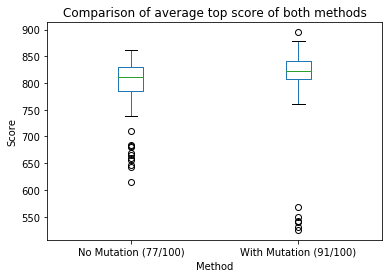

In [29]:
import pandas as pd
gnm = [x['top_score'] for x in no_mutation]
gwm = [x['top_score'] for x in with_mutation]

failed = sum([1 for x in no_mutation if x['top_score'] < 775])
nomutation_label = 'No Mutation (' +str(len(no_mutation)-failed) + '/' + str(len(no_mutation)) + ')'

failed = sum([1 for x in with_mutation if x['top_score'] < 775])
mutation_label = 'With Mutation (' +str(len(with_mutation)-failed) + '/' + str(len(with_mutation)) + ')'

df = pd.DataFrame({nomutation_label:gnm, mutation_label:gwm})
boxplot = df.boxplot(column=[nomutation_label, mutation_label], grid=False)
boxplot.set_title('Comparison of average top score of both methods')
boxplot.set_xlabel('Method')
boxplot.set_ylabel('Score')
display(boxplot)

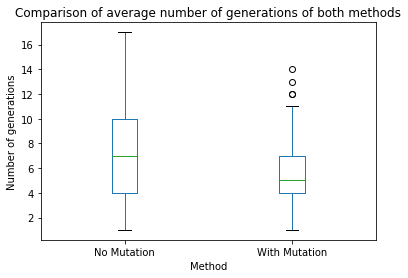

In [28]:
gnm = [x['number_of_generations']-5 for x in no_mutation] # -5 because i care about the iteration where it finds and converges to best solution
gwm = [x['number_of_generations']-5 for x in with_mutation]
df = pd.DataFrame({'No Mutation':gnm, 'With Mutation':gwm})
boxplot = df.boxplot(column=['No Mutation', 'With Mutation'], grid=False)
boxplot.set_title('Comparison of average number of generations of both methods')
boxplot.set_xlabel('Method')
boxplot.set_ylabel('Number of generations')
display(boxplot)